# Analyzing Public Catering Establishments in Toronto
This notebook is for IBM Capstone Project

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#Conclusion)

## Introduction/Business Problem

The outbreak of covid-19, occurred the previous year, has radically changed people’s usual life style. Since that time people have not mostly been able to go out and visit public places. Plenty of cafes and restaurants have been closed down due to imposed restrictions. Taking into account these facts, on the one hand running the restaurant business is a highly risked decision. On the other hand the pandemic is not a persistent global phenomenon, and in some countries including Canada it can be said that it has been brought under control. So that opportunities for recovering business or running the new one are going to appear. Then there may be other possible variants to open a restaurant or cafe such as providing delivery or takeaway options.

A client wants to open a public catering establishment in Toronto and needs to assess what a format of such a place should be chosen. Is it better to open a small pizzeria or an expensive restaurant with a big number of various dishes? The other question is concerned with a pandemic situation. The client wants to estimate risks for both clients and employees. Moreover, in dependence on the number of covid-19 cases in neighborhoods restrictions for public places might be different. Then the client prefers opening their place in a safe neighborhood in terms of crime rate.

## Data

According to the objective, the following factors should be investigated:

* Number of existing public catering establishments in the neighborhoods
* Epidemiological situation in the neighbourhoods
* Crime rates in the neighbourhoods

To resolve all these questions, we will use the following data:

* [The dataset with neighborhood crime rates](https://open.toronto.ca/dataset/neighbourhood-crime-rates/)  is to search for neighborhoods with the low crime rate. Types of crimes should be investigated as well.
* [The dataset with covid-19 cases in Toronto](https://open.toronto.ca/dataset/covid-19-cases-in-toronto/) is to exclude neighborhoods with a high number of new cases
* Foursquare location data is used to obtain the most common food venues in the neighborhoods.
* [The dataset with the coordinates of Toronto neighbourhoods](https://www.kaggle.com/youssef19/toronto-neighborhoods-inforamtion?select=Toronto_neighborhood_demographics_geographics_venues.csv) is for their interactive geospatial visualization 
* [The geo data in the json format](https://github.com/jasonicarter/toronto-geojson/blob/master/toronto_crs84.geojson) is to obtain the coordinates of the neighborhoods for their interactive geospatial visualization on choropleth maps.

### Data preprocessing

In [1]:
import os
import re
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#!pip install geopy
#!pip install folium

from geopy.geocoders import Nominatim

import requests
import json
from urllib.request import urlopen

import folium
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#### Creating data frame with crime rates
We use the open source which is the City of Toronto’s Open Data Portal to get a necessary dataset. The data in this portal is regularly updated. To compose a data frame with crime rates in Toronto, we use the dataset 'Neighbourhood Crime Rates'.

In [2]:
crimeRatesFile = os.path.join(os.getcwd(), 'neighbourhood_crime_rates_05_2021.csv')
crimeRates = pd.read_csv(crimeRatesFile)
crimeRates.head()

_id  OBJECTID            Neighbourhood  Hood_ID  \
0    1         1           Yonge-St.Clair       97   
1    2         2  York University Heights       27   
2    3         3         Lansing-Westgate       38   
3    4         4       Yorkdale-Glen Park       31   
4    5         5      Stonegate-Queensway       16   

   F2020_Population_Projection  Assault_2014  Assault_2015  Assault_2016  \
0                        14083            16            25            34   
1                        30277           273           298           363   
2                        18146            42            81            67   
3                        17560           106           137           175   
4                        27410            91            74            78   

   Assault_2017  Assault_2018  Assault_2019  Assault_2020  Assault_Rate2014  \
0            25            28            35            23          127.0144   
1           351           362           382           341          950.5571   
2            84            68            70            97          261.0966   
3           163           178           210           156          697.5061   
4            98            86            83           104          354.9696   

   Assault_Rate2015  Assault_Rate2016  Assault_Rate2017  Assault_Rate2018  \
0          196.1246          262.5482          189.1790          207.2846   
1         1041.4850         1269.3200         1211.0970         1230.3300   
2          494.6263          400.6698          492.5531          390.1543   
3          902.0279         1149.1990         1031.8410         1086.5580   
4          288.1732          302.5249          374.5318          323.2961   

   Assault_Rate2019  Assault_Rate2020  AutoTheft_2014  AutoTheft_2015  \
0          253.8071          163.3175               2               3   
1         1279.8610         1126.2670             106             100   
2          393.5901          534.5530              17              22   
3         1237.4050          888.3827              63              53   
4          307.3277          379.4236              37              32   

   AutoTheft_2016  AutoTheft_2017  AutoTheft_2018  AutoTheft_2019  \
0               7               2               6               6   
1             106              89              91             147   
2              26              26              16              30   
3              41              54              64              64   
4              14              33              31              35   

   AutoTheft_2020  AutoTheft_Rate2014  AutoTheft_Rate2015  AutoTheft_Rate2016  \
0               9             15.8768            23.53495            54.05405   
1             184            369.0808           349.49150           370.65530   
2              44            105.6820           134.34290           155.48380   
3              87            414.5555           348.95970           269.24090   
4              45            144.3283           124.61540            54.29934   

   AutoTheft_Rate2017  AutoTheft_Rate2018  AutoTheft_Rate2019  \
0            15.13432            44.41812            43.50979   
1           307.08720           309.28190           492.51180   
2           152.45690            91.80102           168.68150   
3           341.83710           390.67270           377.11390   
4           126.11790           116.53700           129.59600   

   AutoTheft_Rate2020  BreakAndEnter_2014  BreakAndEnter_2015  \
0            63.90684                  37                  20   
1           607.72200                 108                 140   
2           242.47770                  34                  27   
3           495.44420                  51                  57   
4           164.17370                  70                  45   

   BreakAndEnter_2016  BreakAndEnter_2017  BreakAndEnter_2018  \
0                  12                  18                  24   
1                  98         

The dataset contains the data by neighbourhood for various crime types. This data includes the count of crimes and the crime rate per 100,000 population for each of the past 7 years. To estimate risks concerned with crime rates for the new public catering establishment, let's consider the more appropriate ones which are robberies and burglaries. Moreover, to make the data more applicable, we will calculate the total number of crimes per neighbourhood and the corresponding mean number of the crime rate for all these years.

In [3]:
crimeRates.rename(columns = {'RobberyRate_2015': 'Robbery_Rate2015'}, inplace = True)
crimeRates = crimeRates[list(crimeRates.filter(regex = 'Neighbourhood|Assault|BreakAndEnter|Robbery').columns)]
crimeRates['Assault_Rate_mean'] = crimeRates.iloc[:, 8:15].mean(axis = 1)
crimeRates['BreakAndEnter_Rate_mean'] = crimeRates.iloc[:, 22:29].mean(axis = 1)
crimeRates.rename(columns = {'BreakAndEnter_Rate_mean': 'Burglaries_Rate_mean'}, inplace = True)
crimeRates['Robbery_Rate_mean'] = crimeRates.iloc[:, 36:43].mean(axis = 1)
crimeRates['Crimes_Total'] = crimeRates.iloc[:, np.r_[1:8, 15:22, 29:36]].sum(axis = 1)
crimeRates.drop(crimeRates.iloc[:, 1:43].columns, axis = 1, inplace = True)
crimeRates.sort_values('Neighbourhood', inplace = True)
crimeRates.reset_index(drop = True, inplace = True)
crimeRates.head()

Neighbourhood  Assault_Rate_mean  Burglaries_Rate_mean  \
0               Agincourt North         244.798486            158.419463   
1  Agincourt South-Malvern West         462.185571            314.380986   
2                     Alderwood         287.495757            209.450686   
3                         Annex         833.750386            475.984500   
4             Banbury-Don Mills         276.324557            234.616229   

   Robbery_Rate_mean  Crimes_Total  
0          94.582293          1067  
1         102.594551          1565  
2          61.767394           497  
3         152.495671          3346  
4          46.386083          1141

#### Creating data frame with COVID-19 cases
We use the open source which is the City of Toronto’s Open Data Portal to get a necessary dataset. The data in this portal is regularly updated. To compose a data frame with COVID-19 cases in Toronto, we use the dataset 'COVID-19 Cases in Toronto'.

In [4]:
covidCasesFile = os.path.join(os.getcwd(), 'COVID19_cases_06_2021.csv')
covidCases = pd.read_csv(covidCasesFile)
covidCases.head()

_id  Assigned_ID Outbreak Associated       Age Group  \
0  2046144            1            Sporadic  50 to 59 Years   
1  2046145            2            Sporadic  50 to 59 Years   
2  2046146            3            Sporadic  20 to 29 Years   
3  2046147            4            Sporadic  60 to 69 Years   
4  2046148            5            Sporadic  60 to 69 Years   

      Neighbourhood Name  FSA Source of Infection Classification Episode Date  \
0        Willowdale East  M2N              Travel      CONFIRMED   2020-01-22   
1        Willowdale East  M2N              Travel      CONFIRMED   2020-01-21   
2      Parkwoods-Donalda  M3A              Travel      CONFIRMED   2020-02-05   
3  Church-Yonge Corridor  M4W              Travel      CONFIRMED   2020-02-16   
4  Church-Yonge Corridor  M4W              Travel      CONFIRMED   2020-02-20   

  Reported Date Client Gender   Outcome Currently Hospitalized  \
0    2020-01-23        FEMALE  RESOLVED                     No   
1    2020-01-23          MALE  RESOLVED                     No   
2    2020-02-21        FEMALE  RESOLVED                     No   
3    2020-02-25        FEMALE  RESOLVED                     No   
4    2020-02-26          MALE  RESOLVED                     No   

  Currently in ICU Currently Intubated Ever Hospitalized Ever in ICU  \
0               No                  No                No          No   
1               No                  No               Yes          No   
2               No                  No                No          No   
3               No                  No                No          No   
4               No                  No                No          No   

  Ever Intubated  
0             No  
1             No  
2             No  
3             No  
4             No

The dataset contains the data by neighbourhood for all confirmed and probable cases since the first one was reported in January 2020. To estimate risks concerned with rates of covid-19 cases for opening the new public catering establishment, let's consider the ones occurred since March 2021.

In [5]:
covidCases = covidCases[['Neighbourhood Name', 'Episode Date']]
covidCases.rename(columns = {'Neighbourhood Name': 'Neighbourhood'}, inplace = True)
covidCases.dropna(axis = 0, inplace = True)
covidCases['Episode Date'] = pd.to_datetime(covidCases['Episode Date'])  
covidCases = covidCases.loc[(covidCases['Episode Date'] > '2021-03-01')]
covidCases.dropna(axis = 0, inplace = True)
covidCasesCount = covidCases.groupby('Neighbourhood').count()
covidCasesCount = covidCasesCount.rename(columns = {'Episode Date': 'Covid_Cases_Total'}).reset_index()
covidCasesCount.head()

Neighbourhood  Covid_Cases_Total
0               Agincourt North                527
1  Agincourt South-Malvern West                560
2                     Alderwood                222
3                         Annex                310
4             Banbury-Don Mills                361

In [6]:
covidCasesCount.shape

(140, 2)

#### Creating data frame with COVID-19 cases and crime rates for each neighbourhood
We combine all the obtained data into one data frame.

In [7]:
diff_df = pd.merge(covidCasesCount, crimeRates, how = 'outer', indicator = 'Exist')
diff_df = diff_df.loc[diff_df['Exist'] != 'both']
diff_df

Neighbourhood  Covid_Cases_Total  Assault_Rate_mean  \
15             Briar Hill - Belgravia              542.0                NaN   
19   Cabbagetown-South St. James Town              212.0                NaN   
29                 Danforth-East York              339.0                NaN   
89               North St. James Town              511.0                NaN   
140              Briar Hill-Belgravia                NaN         555.819800   
141   Cabbagetown-South St.James Town                NaN         956.638129   
142                Danforth East York                NaN         367.700986   
143               North St.James Town                NaN         906.206800   

     Burglaries_Rate_mean  Robbery_Rate_mean  Crimes_Total       Exist  
15                    NaN                NaN           NaN   left_only  
19                    NaN                NaN           NaN   left_only  
29                    NaN                NaN           NaN   left_only  
89                    NaN                NaN           NaN   left_only  
140            249.211343         145.090817         997.0  right_only  
141            544.915500         194.027590        1464.0  right_only  
142            157.138929          38.057456         707.0  right_only  
143            322.349957         161.929457        1926.0  right_only

There are several neighbourhoods whose names are slightly different and they should be fixed.

In [8]:
covidCasesCount.loc[covidCasesCount['Neighbourhood'] == 'Briar Hill - Belgravia', 'Neighbourhood'] = 'Briar Hill-Belgravia'
covidCasesCount.loc[covidCasesCount['Neighbourhood'] == 'Danforth-East York', 'Neighbourhood'] = 'Danforth East York'
covidCasesCount.loc[covidCasesCount['Neighbourhood'] == 'Cabbagetown-South St. James Town', 'Neighbourhood'] = 'Cabbagetown-South St.James Town'
covidCasesCount.loc[covidCasesCount['Neighbourhood'] == 'North St. James Town', 'Neighbourhood'] = 'North St.James Town'

In [9]:
neighbourhoods = pd.merge(covidCasesCount, crimeRates, on = "Neighbourhood")
neighbourhoods.head()

Neighbourhood  Covid_Cases_Total  Assault_Rate_mean  \
0               Agincourt North                527         244.798486   
1  Agincourt South-Malvern West                560         462.185571   
2                     Alderwood                222         287.495757   
3                         Annex                310         833.750386   
4             Banbury-Don Mills                361         276.324557   

   Burglaries_Rate_mean  Robbery_Rate_mean  Crimes_Total  
0            158.419463          94.582293          1067  
1            314.380986         102.594551          1565  
2            209.450686          61.767394           497  
3            475.984500         152.495671          3346  
4            234.616229          46.386083          1141

#### Providing coordinates of neighborhoods
We will use Nominatim geocoder from the geopy library to get the coordinates for the neighborhoods.

In [10]:
neighbourhoodsWithCoordinates = neighbourhoods.reindex(columns = [*neighbourhoods.columns.tolist(), 'Latitude', 'Longitude'])
geolocator = Nominatim(user_agent = "toronto_explorer")

for index, row in neighbourhoodsWithCoordinates.iterrows():
    address = 'Toronto, ' + row['Neighbourhood']
    location = geolocator.geocode(address)
    if location is not None:
        neighbourhoodsWithCoordinates.at[index, 'Latitude'] = location.latitude
        neighbourhoodsWithCoordinates.at[index, 'Longitude'] = location.longitude

neighbourhoodsWithCoordinates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 0 to 139
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Neighbourhood         140 non-null    object 
 1   Covid_Cases_Total     140 non-null    int64  
 2   Assault_Rate_mean     140 non-null    float64
 3   Burglaries_Rate_mean  140 non-null    float64
 4   Robbery_Rate_mean     140 non-null    float64
 5   Crimes_Total          140 non-null    int64  
 6   Latitude              100 non-null    float64
 7   Longitude             100 non-null    float64
dtypes: float64(5), int64(2), object(1)
memory usage: 14.8+ KB


In [11]:
neighbourhoodsWithCoordinates.head()

Neighbourhood  Covid_Cases_Total  Assault_Rate_mean  \
0               Agincourt North                527         244.798486   
1  Agincourt South-Malvern West                560         462.185571   
2                     Alderwood                222         287.495757   
3                         Annex                310         833.750386   
4             Banbury-Don Mills                361         276.324557   

   Burglaries_Rate_mean  Robbery_Rate_mean  Crimes_Total   Latitude  Longitude  
0            158.419463          94.582293          1067  43.808038 -79.266439  
1            314.380986         102.594551          1565        NaN        NaN  
2            209.450686          61.767394           497  43.601717 -79.545232  
3            475.984500         152.495671          3346  43.670338 -79.407117  
4            234.616229          46.386083          1141        NaN        NaN

The data obtained with the use of Nominatim geocoder contains a lot of null coordinates.
Moreover, these results are changed from time to time which is not convenient for the current work.
To get the coordinates for more neighbourhoods, [the dataset with the coordinates of Toronto neighbourhoods](https://www.kaggle.com/youssef19/toronto-neighborhoods-inforamtion?select=Toronto_neighborhood_demographics_geographics_venues.csv) will be used.

In [12]:
neighbourhoodCoordinatesFile = os.path.join(os.getcwd(), 'Toronto_neighborhood_demographics_geographics_venues.csv')
neighbourhoodCoordinates = pd.read_csv(neighbourhoodCoordinatesFile,  converters = {'long_latt': eval})
neighbourhoodCoordinates[['Longitude', 'Latitude']] = pd.DataFrame(neighbourhoodCoordinates.long_latt.tolist(), index = neighbourhoodCoordinates.index)
neighbourhoodCoordinates.rename(columns = {'Neighborhood': 'Neighbourhood'}, inplace = True)
neighbourhoodCoordinates.head()

Neighbourhood  Total population  number of educated people  \
0               Agincourt North           30280.0                    19805.0   
1  Agincourt South-Malvern West           21990.0                    14535.0   
2                     Alderwood           11900.0                     7915.0   
3                         Annex           29180.0                    23495.0   
4             Banbury-Don Mills           26910.0                    20555.0   

   number of 15-45  number of employers  \
0          11850.0              13230.0   
1           8840.0               9860.0   
2           4520.0               6240.0   
3          15095.0              16770.0   
4           9615.0              13030.0   

                               long_latt  number_gyms  number_venues  \
0   [-79.2816161258827, 43.797405754163]          0.0           26.0   
1  [-79.2891688527481, 43.7851873380096]          0.0           34.0   
2  [-79.5532040267975, 43.5954996876866]          1.0           17.0   
3  [-79.4121466573202, 43.6744312990078]          3.0           63.0   
4   [-79.326504539789, 43.7325704244428]          2.0           14.0   

   Longitude   Latitude  
0 -79.281616  43.797406  
1 -79.289169  43.785187  
2 -79.553204  43.595500  
3 -79.412147  43.674431  
4 -79.326505  43.732570

In [13]:
diff_df = pd.merge(neighbourhoods, neighbourhoodCoordinates, how = 'outer', indicator = 'Exist')
diff_df = diff_df.loc[diff_df['Exist'] != 'both']
diff_df

Neighbourhood  Covid_Cases_Total  Assault_Rate_mean  \
19    Cabbagetown-South St.James Town              212.0         956.638129   
89                North St.James Town              511.0         906.206800   
127                Weston-Pellam Park              447.0         782.616443   
140  Cabbagetown-South St. James Town                NaN                NaN   
141              North St. James Town                NaN                NaN   
142                Weston-Pelham Park                NaN                NaN   

     Burglaries_Rate_mean  Robbery_Rate_mean  Crimes_Total  Total population  \
19             544.915500         194.027590        1464.0               NaN   
89             322.349957         161.929457        1926.0               NaN   
127            178.861847         102.364556         878.0               NaN   
140                   NaN                NaN           NaN           12050.0   
141                   NaN                NaN           NaN           17825.0   
142                   NaN                NaN           NaN           12015.0   

     number of educated people  number of 15-45  number of employers  \
19                         NaN              NaN                  NaN   
89                         NaN              NaN                  NaN   
127                        NaN              NaN                  NaN   
140                     9595.0           5335.0               7155.0   
141                    13355.0           9720.0               8935.0   
142                     6240.0           5390.0               5680.0   

                                   long_latt  number_gyms  number_venues  \
19                                       NaN          NaN            NaN   
89                                       NaN          NaN            NaN   
127                                      NaN          NaN            NaN   
140    [-79.3713421467449, 43.6718887916088]          0.0           87.0   
141     [-79.376270792038, 43.6664293113267]          1.0           98.0   
142  [-79.4569297958965, 43.676759807917406]          0.0           23.0   

     Longitude   Latitude       Exist  
19         NaN        NaN   left_only  
89         NaN        NaN   left_only  
127        NaN        NaN   left_only  
140 -79.371342  43.671889  right_only  
141 -79.376271  43.666429  right_only  
142 -79.456930  43.676760  right_only

There are several neighbourhoods whose names are slightly different and they should be fixed.

In [14]:
neighbourhoodCoordinates.loc[neighbourhoodCoordinates['Neighbourhood'] == 'Weston-Pelham Park', 'Neighbourhood'] = 'Weston-Pellam Park'
neighbourhoodCoordinates.loc[neighbourhoodCoordinates['Neighbourhood'] == 'Cabbagetown-South St. James Town', 'Neighbourhood'] = 'Cabbagetown-South St.James Town'
neighbourhoodCoordinates.loc[neighbourhoodCoordinates['Neighbourhood'] == 'North St. James Town', 'Neighbourhood'] = 'North St.James Town'

In [15]:
neighbourhoods = pd.merge(neighbourhoods, neighbourhoodCoordinates[['Neighbourhood', 'Longitude', 'Latitude']], on = "Neighbourhood")
neighbourhoods.head()

Neighbourhood  Covid_Cases_Total  Assault_Rate_mean  \
0               Agincourt North                527         244.798486   
1  Agincourt South-Malvern West                560         462.185571   
2                     Alderwood                222         287.495757   
3                         Annex                310         833.750386   
4             Banbury-Don Mills                361         276.324557   

   Burglaries_Rate_mean  Robbery_Rate_mean  Crimes_Total  Longitude   Latitude  
0            158.419463          94.582293          1067 -79.281616  43.797406  
1            314.380986         102.594551          1565 -79.289169  43.785187  
2            209.450686          61.767394           497 -79.553204  43.595500  
3            475.984500         152.495671          3346 -79.412147  43.674431  
4            234.616229          46.386083          1141 -79.326505  43.732570

In [16]:
neighbourhoods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 0 to 139
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Neighbourhood         140 non-null    object 
 1   Covid_Cases_Total     140 non-null    int64  
 2   Assault_Rate_mean     140 non-null    float64
 3   Burglaries_Rate_mean  140 non-null    float64
 4   Robbery_Rate_mean     140 non-null    float64
 5   Crimes_Total          140 non-null    int64  
 6   Longitude             140 non-null    float64
 7   Latitude              140 non-null    float64
dtypes: float64(5), int64(2), object(1)
memory usage: 9.8+ KB


Now we have the coordinates for all neighbourhoods.

## Methodology

### Data Visualization
We will use the Folium library to visualize Toronto neighbourhoods on the interactive map.

#### Getting coordinates of Toronto
We will use Nominatim geocoder from the geopy library to get the latitude and longitude values of Toronto

In [17]:
address = 'Toronto'
geolocator = Nominatim(user_agent = "toronto_explorer")
location = geolocator.geocode(address)
torontoLatitude = location.latitude
torontoLongitude = location.longitude
print('The geographical coordinates of Toronto are {}, {}.'.format(torontoLatitude, torontoLongitude))

The geographical coordinates of Toronto are 43.6534817, -79.3839347.


#### Creating map of Toronto with neighbourhoods
We will use the folium library to visualize the Toronto neighbourhoods

In [18]:
map_toronto = folium.Map(location = [torontoLatitude, torontoLongitude], zoom_start = 10)

for lat, lng, neighbourhood in zip(neighbourhoods['Latitude'], neighbourhoods['Longitude'],  neighbourhoods['Neighbourhood']):
    labelStr = '{}'.format(neighbourhood)
    label = folium.Popup(labelStr, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_toronto)  
    
map_toronto

### The map is stored as 'Toronto neighbourhoods.png'

### Exploring Neighborhoods of Toronto

#### Defining Foursquare Credentials and Version

In [19]:
with open('info.txt') as info:
    data = json.load(info)
    CLIENT_ID = data['id']
    CLIENT_SECRET = data['secret']
    ACCESS_TOKEN = data['token']
    VERSION = data['version']

#### Estimating how many categories of public catering establishments exist

Creating the GET request URL.

In [20]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
results = requests.get(url).json()["response"]['categories']

Getting data with food venue categories.

In [21]:
foodCategory = None
for category in results:
    if category['name'] == 'Food':
        foodCategory = category
foodCategories = pd.json_normalize(foodCategory['categories'])
foodCategories.head()

id                 name            pluralName  \
0  503288ae91d4c4b30a586d67    Afghan Restaurant    Afghan Restaurants   
1  4bf58dd8d48988d1c8941735   African Restaurant   African Restaurants   
2  4bf58dd8d48988d14e941735  American Restaurant  American Restaurants   
3  5f2c2b7db6d05514c7044837  Armenian Restaurant  Armenian Restaurants   
4  4bf58dd8d48988d142941735     Asian Restaurant     Asian Restaurants   

  shortName                                         categories  \
0    Afghan                                                 []   
1   African  [{'id': '4bf58dd8d48988d10a941735', 'name': 'E...   
2  American  [{'id': '4bf58dd8d48988d157941735', 'name': 'N...   
3  Armenian                                                 []   
4     Asian  [{'id': '56aa371be4b08b9a8d573568', 'name': 'B...   

                                         icon.prefix icon.suffix  
0  https://ss3.4sqi.net/img/categories_v2/food/af...        .png  
1  https://ss3.4sqi.net/img/categories_v2/food/af...        .png  
2  https://ss3.4sqi.net/img/categories_v2/food/de...        .png  
3  https://ss3.4sqi.net/img/categories_v2/food/de...        .png  
4  https://ss3.4sqi.net/img/categories_v2/food/as...        .png

We have got a data frame with food venue categories. But it's still incomprehensible how many category levels in it.
Let's define a function to normalize data with venue categories and get their names.

#### Defining function to normalize data with venue categoiries and get their names

In [22]:
def normalizeCategoriesData(categoriesData, categoriesDF, level = 0):
    if level == 0:
        record_path = None
        meta = None
        record_prefix = ''
        columns = ['name', 'categories']
    else:
        record_path = ['categories'] * level
        meta = []
        record_prefix = 'level' + '{}'.format(level) + '.'
        columns = ['name', record_prefix + 'categories']
        for i in range(level):
            path = ['categories'] * i + ['name']
            prefix = 'level' + '{}'.format(i + 1) + '.'
            column = [prefix + 'name']
            columns.extend(column)
            meta.append(path)
    tempCategoriesDF = pd.json_normalize(categoriesData['categories'], record_path, meta, record_prefix = record_prefix)
    if level > 1:
        for i in range(1, level):
            tempCategoriesDF.rename(columns={'.'.join(meta[i]) : 'level' + '{}'.format(i) + '.name'}, inplace = True)
    tempCategoriesDF = tempCategoriesDF[columns]
    lastCategoriesDF = tempCategoriesDF[tempCategoriesDF[record_prefix + 'categories'].str.len() == 0]
    categoriesDF = pd.concat([categoriesDF, lastCategoriesDF], ignore_index=True)

    if tempCategoriesDF[record_prefix + 'categories'].str.len().any():
        level += 1
        return normalizeCategoriesData(categoriesData, categoriesDF, level)
    else:   
        cols = [column for column in categoriesDF.columns if 'categories' not in column]
        categoriesDF = categoriesDF[cols]
        categoriesDF.rename(columns = {'name': 'level0.name'}, inplace = True)
        return categoriesDF

#### Creating data frame with all food venue categories available in Foursquare

In [23]:
foodCategoriesDF = pd.DataFrame()
foodCategoriesDF = normalizeCategoriesData(foodCategory, foodCategoriesDF)
foodCategoriesDF.tail()

level0.name                level1.name  \
321  Latin American Restaurant  South American Restaurant   
322  Latin American Restaurant  South American Restaurant   
323  Latin American Restaurant  South American Restaurant   
324  Latin American Restaurant  South American Restaurant   
325  Latin American Restaurant  South American Restaurant   

              level2.name                        level3.name  
321  Brazilian Restaurant                         Pastelaria  
322  Brazilian Restaurant  Southeastern Brazilian Restaurant  
323  Brazilian Restaurant      Southern Brazilian Restaurant  
324  Brazilian Restaurant                         Tapiocaria  
325   Peruvian Restaurant       Peruvian Roast Chicken Joint

In [24]:
print("There are {} unique categories of food venues consisted of no more than {} levels.".format(foodCategoriesDF.shape[0], foodCategoriesDF.shape[1]))

There are 326 unique categories of food venues consisted of no more than 4 levels.


#### Defining function to get nearby venues
We need a function to get venues for each neighbourhood

In [25]:
def getNearbyVenues(names, latitudes, longitudes, categoryId, radius = 600):
    print("The following neighbourhoods contain venues from the food category:")
    venuesList = []
    noVenuesList = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('  ' + name)     
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            categoryId)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        if len(results) != 0:
            venuesList.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        else:
            noVenuesList.append(name)
            venuesList.append([(name, lat, lng, np.NaN, np.NaN, np.NaN, np.NaN)])
            
    nearbyVenues = pd.DataFrame([item for venueList in venuesList for item in venueList])
    nearbyVenues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print("\nThe following neighbourhoods don't contain any venues from the food category:")
    for name in noVenuesList:
        print('  ' + name)

    return(nearbyVenues)

#### Creating data frame with food venues in Toronto

In [26]:
torontoFoodVenues = getNearbyVenues(neighbourhoods['Neighbourhood'], neighbourhoods['Latitude'], neighbourhoods['Longitude'], foodCategory['id'])

The following neighbourhoods contain venues from the food category:
  Agincourt North
  Agincourt South-Malvern West
  Alderwood
  Annex
  Banbury-Don Mills
  Bathurst Manor
  Bay Street Corridor
  Bayview Village
  Bayview Woods-Steeles
  Bedford Park-Nortown
  Beechborough-Greenbrook
  Bendale
  Birchcliffe-Cliffside
  Black Creek
  Blake-Jones
  Briar Hill-Belgravia
  Bridle Path-Sunnybrook-York Mills
  Broadview North
  Brookhaven-Amesbury
  Cabbagetown-South St.James Town
  Caledonia-Fairbank
  Casa Loma
  Centennial Scarborough
  Church-Yonge Corridor
  Clairlea-Birchmount
  Clanton Park
  Cliffcrest
  Corso Italia-Davenport
  Danforth
  Danforth East York
  Don Valley Village
  Dorset Park
  Dovercourt-Wallace Emerson-Junction
  Downsview-Roding-CFB
  Dufferin Grove
  East End-Danforth
  Edenbridge-Humber Valley
  Eglinton East
  Elms-Old Rexdale
  Englemount-Lawrence
  Eringate-Centennial-West Deane
  Etobicoke West Mall
  Flemingdon Park
  Forest Hill North
  Forest Hill South

In [27]:
torontoFoodVenues.head()

Neighbourhood  Neighbourhood Latitude  \
0               Agincourt North               43.797406   
1               Agincourt North               43.797406   
2  Agincourt South-Malvern West               43.785187   
3  Agincourt South-Malvern West               43.785187   
4  Agincourt South-Malvern West               43.785187   

   Neighbourhood Longitude              Venue  Venue Latitude  \
0               -79.281616             Subway       43.797503   
1               -79.281616                 凱聲       43.801003   
2               -79.289169        Burger King       43.784205   
3               -79.289169             Subway       43.783728   
4               -79.289169  Congee Queen 皇后名粥       43.783910   

   Venue Longitude        Venue Category  
0       -79.282181        Sandwich Place  
1       -79.283363      Asian Restaurant  
2       -79.292606  Fast Food Restaurant  
3       -79.292873        Sandwich Place  
4       -79.292319  Cantonese Restaurant

In [28]:
torontoFoodVenues.sort_values('Venue Category', inplace = True)
torontoFoodVenues.reset_index(drop = True, inplace = True)
torontoFoodVenues.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0      Elms-Old Rexdale               43.729832               -79.553080   
1                 Rouge               43.803697               -79.200182   
2             Casa Loma               43.686641               -79.401455   
3             Moss Park               43.652704               -79.372792   
4  Bedford Park-Nortown               43.709604               -79.427423   

                 Venue  Venue Latitude  Venue Longitude       Venue Category  
0      Etob Restaurant       43.725495       -79.551275   African Restaurant  
1              Mr Jerk       43.801262       -79.199758   African Restaurant  
2  Union Social Eatery       43.687895       -79.394916  American Restaurant  
3     Richmond Station       43.651569       -79.379266  American Restaurant  
4       Kosher Gourmet       43.713176       -79.432003  American Restaurant

In [29]:
print('There are {} food venues in {} Toronto neighbourhoods.'.format(torontoFoodVenues.dropna().shape[0], len(torontoFoodVenues.dropna()['Neighbourhood'].unique())))

There are 1451 food venues in 126 Toronto neighbourhoods.


In [30]:
print('There are {} unique categories of food venues in Toronto neighbourhoods.'.format(len(torontoFoodVenues.dropna()['Venue Category'].unique())))

There are 93 unique categories of food venues in Toronto neighbourhoods.


In [31]:
torontoNoFoodVenues = torontoFoodVenues[pd.isnull(torontoFoodVenues).any(axis=1)]
torontoNoFoodVenues.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
1451               Alderwood               43.595500               -79.553204   
1452  Centennial Scarborough               43.769728               -79.145626   
1453              Cliffcrest               43.711273               -79.225220   
1454              Humbermede               43.735709               -79.549080   
1455             Long Branch               43.589748               -79.524738   

     Venue  Venue Latitude  Venue Longitude Venue Category  
1451   NaN             NaN              NaN            NaN  
1452   NaN             NaN              NaN            NaN  
1453   NaN             NaN              NaN            NaN  
1454   NaN             NaN              NaN            NaN  
1455   NaN             NaN              NaN            NaN

In [32]:
print('There are {} Toronto neighbourhoods without any food venues.'.format(len(torontoNoFoodVenues['Neighbourhood'].unique())))

There are 14 Toronto neighbourhoods without any food venues.


These neighbourhoods can be considered as a possible place to open a food venue. 

#### Creating new data frame with all food venue categories available in Foursquare without hierarchy

The problem is that names of food venue categories in Toronto can correspond to any level of the ones in available in Foursquare. To compare food venue categories existing in Toronto and presented in Foursquare, we need to combine data with all possible food venue categories to make them of the same level.

In [33]:
uniqueFoodCategoriesDF = pd.DataFrame()
for column in foodCategoriesDF.columns:
    tempDF = pd.DataFrame(foodCategoriesDF[column].dropna().unique(), columns = ['Venue Category'])
    uniqueFoodCategoriesDF = pd.concat([uniqueFoodCategoriesDF, tempDF], ignore_index = True)
uniqueFoodCategoriesDF.sort_values('Venue Category', inplace = True)
uniqueFoodCategoriesDF.reset_index(drop = True, inplace = True)
uniqueFoodCategoriesDF.head()

Venue Category
0   Abruzzo Restaurant
1           Acai House
2  Acehnese Restaurant
3    Afghan Restaurant
4   African Restaurant

Let's estimate how many food venue categories don't exist in Toronto.

In [34]:
mergedByAllFoodVenues = pd.merge(uniqueFoodCategoriesDF, torontoFoodVenues, how = 'left', indicator = True, on = 'Venue Category')
mergedByAllFoodVenues = mergedByAllFoodVenues[mergedByAllFoodVenues['_merge'] == 'left_only']
mergedByAllFoodVenues.reset_index(drop = True, inplace = True)
mergedByAllFoodVenues.head()

Venue Category Neighbourhood  Neighbourhood Latitude  \
0   Abruzzo Restaurant           NaN                     NaN   
1           Acai House           NaN                     NaN   
2  Acehnese Restaurant           NaN                     NaN   
3    Afghan Restaurant           NaN                     NaN   
4          Agriturismo           NaN                     NaN   

   Neighbourhood Longitude Venue  Venue Latitude  Venue Longitude     _merge  
0                      NaN   NaN             NaN              NaN  left_only  
1                      NaN   NaN             NaN              NaN  left_only  
2                      NaN   NaN             NaN              NaN  left_only  
3                      NaN   NaN             NaN              NaN  left_only  
4                      NaN   NaN             NaN              NaN  left_only

In [35]:
print("There are roughly {} food venue categories which don't exist in Toronto".format(mergedByAllFoodVenues.shape[0]))

There are roughly 265 food venue categories which don't exist in Toronto


However, this number is not precise since names of some food venue categories exist for each level in the new composed data frame, and some food venue categories available in Toronto have a common category such as ‘Restaurant’ which might have been specified more accurately.

In [36]:
mergedByTorontoFoodVenues = pd.merge(uniqueFoodCategoriesDF, torontoFoodVenues, how = 'right', indicator = True, on = 'Venue Category')
mergedByTorontoFoodVenues = mergedByTorontoFoodVenues[mergedByTorontoFoodVenues['_merge'] == 'right_only']
mergedByTorontoFoodVenues.reset_index(drop = True, inplace = True)
mergedByTorontoFoodVenues

Venue Category             Neighbourhood  Neighbourhood Latitude  \
0            Food                   Niagara               43.638903   
1            Food            Dufferin Grove               43.652743   
2            Food         Woodbine Corridor               43.672073   
3            Food                  Oakridge               43.716585   
4            Food                   Malvern               43.788985   
5            Food            South Parkdale               43.632999   
6            Food  Humber Heights-Westmount               43.680013   
7             NaN                 Alderwood               43.595500   
8             NaN    Centennial Scarborough               43.769728   
9             NaN                Cliffcrest               43.711273   
10            NaN                Humbermede               43.735709   
11            NaN               Long Branch               43.589748   
12            NaN             Old East York               43.703079   
13            NaN        Princess-Rosethorn               43.652908   
14            NaN       Scarborough Village               43.728497   
15            NaN           South Riverdale               43.643181   
16            NaN       Stonegate-Queensway               43.641230   
17            NaN          Victoria Village               43.716326   
18            NaN                 West Hill               43.775687   
19            NaN       Westminster-Branson               43.767052   
20            NaN   York University Heights               43.762715   

    Neighbourhood Longitude                               Venue  \
0                -79.420759  Liberty Village Rotisserie & Grill   
1                -79.431641                       The Depanneur   
2                -79.309942               Beaches Natural Foods   
3                -79.304827                 Sunrise Bar & Grill   
4                -79.225960                       Catering Club   
5                -79.438836                     Urban Herbivore   
6                -79.506078                            Pringles   
7                -79.553204                                 NaN   
8                -79.145626                                 NaN   
9                -79.225220                                 NaN   
10               -79.549080                                 NaN   
11               -79.524738                                 NaN   
12               -79.335690                                 NaN   
13               -79.537482                                 NaN   
14               -79.220031                                 NaN   
15               -79.334252                                 NaN   
16               -79.484967                                 NaN   
17               -79.322446                                 NaN   
18               -79.196080                                 NaN   
19               -79.447001                                 NaN   
20               -79.508090                                 NaN   

    Venue Latitude  Venue Longitude      _merge  
0        43.639941       -79.422095  right_only  
1        43.652904       -79.429575  right_only  
2        43.669265       -79.303633  right_only  
3        43.719829       -79.301050  right_only  
4        43.792914       -79.222192  right_only  
5        43.636648       -79.435984  right_only  
6        43.675705       -79.507663  right_only  
7              NaN              NaN  right_only  
8              NaN              NaN  right_only  
9              NaN              NaN  right_only  
10             NaN              NaN  right_only  
11             NaN              NaN  right_only  
12             NaN              NaN  right_only  
13             NaN              NaN  right_only  
14             NaN              NaN  right_only  
15             NaN              NaN  right_only  
16             NaN              NaN  right_only  
17             NaN              NaN  right_only  
18             

In [37]:
print("There are {} neighbourhoods without any food venues and there are {} venues of an ambiguous food category.".format(mergedByTorontoFoodVenues.isnull().any(axis=1).sum(), mergedByTorontoFoodVenues.notnull().all(axis = 1).sum()))

There are 14 neighbourhoods without any food venues and there are 7 venues of an ambiguous food category.


Venues of the 'Food' category we will drop as it doesn't give us useful information.

In [38]:
torontoFoodVenues.drop(index = torontoFoodVenues[torontoFoodVenues['Venue Category'] == 'Food'].index, inplace = True)
torontoFoodVenues.reset_index(drop = True, inplace = True)
torontoFoodVenues.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0      Elms-Old Rexdale               43.729832               -79.553080   
1                 Rouge               43.803697               -79.200182   
2             Casa Loma               43.686641               -79.401455   
3             Moss Park               43.652704               -79.372792   
4  Bedford Park-Nortown               43.709604               -79.427423   

                 Venue  Venue Latitude  Venue Longitude       Venue Category  
0      Etob Restaurant       43.725495       -79.551275   African Restaurant  
1              Mr Jerk       43.801262       -79.199758   African Restaurant  
2  Union Social Eatery       43.687895       -79.394916  American Restaurant  
3     Richmond Station       43.651569       -79.379266  American Restaurant  
4       Kosher Gourmet       43.713176       -79.432003  American Restaurant

#### Assessing total number of food venues in each neighbourhood

In [39]:
foodVenuesCount = torontoFoodVenues[['Neighbourhood', 'Venue Category']].groupby('Neighbourhood').count()
foodVenuesCount.rename(columns={'Venue Category': 'Total_Food_Venues'}, inplace = True)
foodVenuesCount.sort_values('Total_Food_Venues', ascending = False, inplace = True)
foodVenuesCount.reset_index(inplace = True)
foodVenuesCount.head()

Neighbourhood  Total_Food_Venues
0       Little Portugal                 30
1   Mount Pleasant East                 30
2          Roncesvalles                 30
3   North St.James Town                 30
4  Kensington-Chinatown                 30

Text(0, 0.5, 'Number of Neighbourhoods')

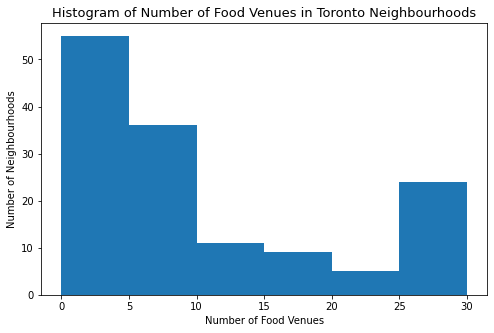

In [40]:
_, bin_edges = np.histogram(foodVenuesCount['Total_Food_Venues'], bins = 6) 
foodVenuesCount['Total_Food_Venues'].plot(kind = 'hist', bins = 6, xticks = bin_edges, figsize = (8, 5))
plt.title("Histogram of Number of Food Venues in Toronto Neighbourhoods", fontsize = 13)
plt.xlabel('Number of Food Venues')
plt.ylabel('Number of Neighbourhoods')

In [41]:
print('There are {} neighbourhoods with less than 5 food venues.'.format(len(foodVenuesCount[foodVenuesCount['Total_Food_Venues'] < 5])))

There are 55 neighbourhoods with less than 5 food venues.


In [42]:
print('There are {} neighbourhoods with more than 25 food venues.'.format(len(foodVenuesCount[foodVenuesCount['Total_Food_Venues'] > 25])))

There are 24 neighbourhoods with more than 25 food venues.


We can observe from these results that there are plenty of neighbourhoods where only a few food venues exist. On the other hand in some neighbourhoods many such places have already opened.

The results don't imply that a new food venue should be opened in a neighbourhood with less number of places. There may be many reasons why some neighbourhoods attract owners to open their restaurants and the others don't.

#### Assessing total number of venues in each food venue category

In [43]:
foodVenueCategoriesCount = torontoFoodVenues[['Venue Category', 'Venue']].groupby('Venue Category').count()
foodVenueCategoriesCount.rename(columns={'Venue': 'Total_Food_Venues'}, inplace = True)
foodVenueCategoriesCount.sort_values('Total_Food_Venues', ascending = False, inplace = True)
foodVenueCategoriesCount.reset_index(inplace = True)
foodVenueCategoriesCount.head()

Venue Category  Total_Food_Venues
0            Café                114
1     Pizza Place                112
2      Restaurant                100
3  Sandwich Place                 91
4          Bakery                 77

Let's plot a bar chart with the total number of venues in each food venue category existing in Toronto. Since there are a lot of food venue categories, we can confine to the ones whose count is more than 30. 

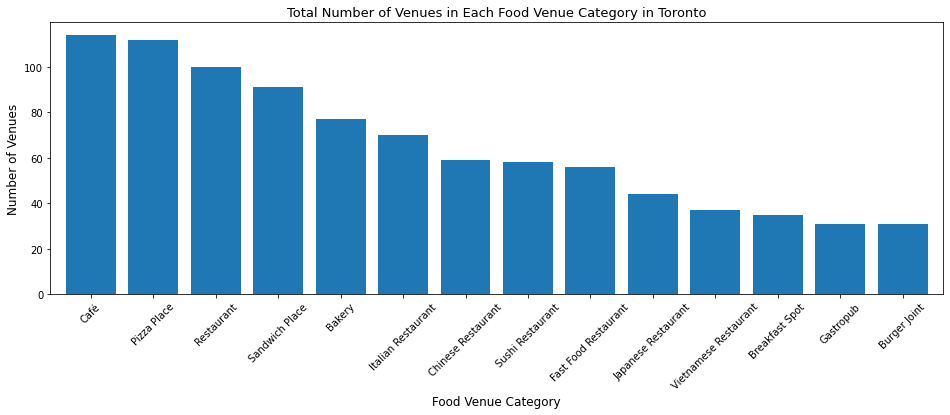

In [44]:
axes = foodVenueCategoriesCount.loc[foodVenueCategoriesCount['Total_Food_Venues'] > 30].plot(kind = 'bar', figsize = (16, 5), width = 0.8)
axes.set_xticklabels(foodVenueCategoriesCount['Venue Category'])
plt.title("Total Number of Venues in Each Food Venue Category in Toronto", fontsize = 13)
plt.xlabel('Food Venue Category', fontsize = 12)
plt.xticks(rotation = 45)
plt.ylabel('Number of Venues', fontsize = 12)
axes.get_legend().remove()

It's clear from the bar chart that most of food venues fall into the following categories: cafes, pizza and sandwich places, bakeries, various restaurants, especially the Italian, Asian and Fast Food ones. 

Let's plot a histogram of the venues in food venue categories in Toronto. 

Text(0, 0.5, 'Number of Venues Categories')

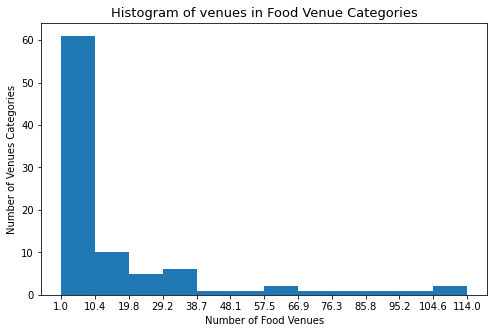

In [45]:
_, bin_edges = np.histogram(foodVenueCategoriesCount['Total_Food_Venues'], bins = 12)
foodVenueCategoriesCount['Total_Food_Venues'].plot(kind = 'hist', bins = 12, xticks = bin_edges, figsize = (8, 5))
plt.title("Histogram of venues in Food Venue Categories", fontsize = 13)
plt.xlabel('Number of Food Venues')
plt.ylabel('Number of Venues Categories')

In [46]:
print('No more than 10 venues exist for {} food venue categories.'.format(len(foodVenueCategoriesCount[foodVenueCategoriesCount['Total_Food_Venues'] < 11])))

No more than 10 venues exist for 61 food venue categories.


In addition to the previous results we can observe that among food venue categories, existing in Toronto, only a few venues are presented for most of them.

#### Creating data frame with food venue categories
Let's analyze food venues in each neighbourhood.

In [47]:
torontoFoodCategories = pd.get_dummies(torontoFoodVenues[['Venue Category']], prefix = "", prefix_sep= "")
torontoFoodCategories.insert(loc = 0, column = 'Neighbourhood', value = torontoFoodVenues['Neighbourhood'])
torontoFoodCategories.sort_values('Neighbourhood', inplace = True)
torontoFoodCategories.reset_index(drop = True, inplace = True)
torontoFoodCategories.head()

Neighbourhood  African Restaurant  American Restaurant  \
0               Agincourt North                   0                    0   
1               Agincourt North                   0                    0   
2  Agincourt South-Malvern West                   0                    0   
3  Agincourt South-Malvern West                   0                    0   
4  Agincourt South-Malvern West                   0                    0   

   Asian Restaurant  BBQ Joint  Bagel Shop  Bakery  Belgian Restaurant  \
0                 1          0           0       0                   0   
1                 0          0           0       0                   0   
2                 0          0           0       0                   0   
3                 0          0           0       0                   0   
4                 0          0           0       0                   0   

   Bistro  Brazilian Restaurant  Breakfast Spot  Burger Joint  Burrito Place  \
0       0                     0               0             0              0   
1       0                     0               0             0              0   
2       0                     0               0             0              0   
3       0                     0               0             0              1   
4       0                     0               0             0              0   

   Cafeteria  Café  Cajun / Creole Restaurant  Cambodian Restaurant  \
0          0     0                          0                     0   
1          0     0                          0                     0   
2          0     0                          0                     0   
3          0     0                          0                     0   
4          0     0                          0                     0   

   Cantonese Restaurant  Caribbean Restaurant  Chinese Restaurant  \
0                     0                     0                   0   
1                     0                     0                   0   
2                     0                     0                   0   
3                     0                     0                   0   
4                     0                     0                   1   

   Comfort Food Restaurant  Creperie  Cuban Restaurant  Deli / Bodega  \
0                        0         0                 0              0   
1                        0         0                 0              0   
2                        0         0                 0              1   
3                        0         0                 0              0   
4                        0         0                 0              0   

   Dim Sum Restaurant  Diner  Doner Restaurant  Donut Shop  \
0                   0      0                 0           0   
1                   0      0                 0           0   
2                   0      0                 0           0   
3                   0      0                 0           0   
4                   0      0                 0           0   

   Dumpling Restaurant  Eastern European Restaurant  Egyptian Restaurant  \
0                    0                            0                    0   
1                    0                            0                    0   
2                    0                            0                    0   
3                    0                            0                    0   
4                    0                            0                    0   

   Ethiopian Restaurant  Falafel Restaurant  Fast Food Restaurant  \
0                     0                   0                     0   
1                     0                   0                     0   
2                     0                   0                     0   
3                     0                   0                     0   
4                     0                   0                     0   

   Filipino Restaurant  Fish & Chips Shop  Food Court  Food Truck  \
0                    0                  

#### Creating data frame with the mean of the frequency of occurrence of each category in neighborhoods

In [48]:
torontoFoodCategoriesGrouped = torontoFoodCategories.groupby('Neighbourhood').mean().reset_index()
torontoFoodCategoriesGrouped.head()

Neighbourhood  African Restaurant  American Restaurant  \
0               Agincourt North                 0.0                  0.0   
1  Agincourt South-Malvern West                 0.0                  0.0   
2                     Alderwood                 0.0                  0.0   
3                         Annex                 0.0                  0.0   
4             Banbury-Don Mills                 0.0                  0.0   

   Asian Restaurant  BBQ Joint  Bagel Shop    Bakery  Belgian Restaurant  \
0          0.500000        0.0         0.0  0.000000                 0.0   
1          0.000000        0.0         0.0  0.076923                 0.0   
2          0.000000        0.0         0.0  0.000000                 0.0   
3          0.034483        0.0         0.0  0.000000                 0.0   
4          0.000000        0.0         0.0  0.000000                 0.0   

     Bistro  Brazilian Restaurant  Breakfast Spot  Burger Joint  \
0  0.000000                   0.0        0.000000      0.000000   
1  0.000000                   0.0        0.000000      0.000000   
2  0.000000                   0.0        0.000000      0.000000   
3  0.034483                   0.0        0.034483      0.068966   
4  0.000000                   0.0        0.000000      0.000000   

   Burrito Place  Cafeteria      Café  Cajun / Creole Restaurant  \
0       0.000000        0.0  0.000000                        0.0   
1       0.076923        0.0  0.000000                        0.0   
2       0.000000        0.0  0.000000                        0.0   
3       0.000000        0.0  0.137931                        0.0   
4       0.000000        0.0  0.000000                        0.0   

   Cambodian Restaurant  Cantonese Restaurant  Caribbean Restaurant  \
0                   0.0              0.000000                   0.0   
1                   0.0              0.076923                   0.0   
2                   0.0              0.000000                   0.0   
3                   0.0              0.000000                   0.0   
4                   0.0              0.000000                   0.0   

   Chinese Restaurant  Comfort Food Restaurant  Creperie  Cuban Restaurant  \
0            0.000000                      0.0       0.0               0.0   
1            0.153846                      0.0       0.0               0.0   
2            0.000000                      0.0       0.0               0.0   
3            0.000000                      0.0       0.0               0.0   
4            0.000000                      0.0       0.0               0.0   

   Deli / Bodega  Dim Sum Restaurant     Diner  Doner Restaurant  Donut Shop  \
0       0.000000                 0.0  0.000000               0.0    0.000000   
1       0.076923                 0.0  0.000000               0.0    0.000000   
2       0.000000                 0.0  0.000000               0.0    0.000000   
3       0.034483                 0.0  0.068966               0.0    0.034483   
4       0.250000                 0.0  0.000000               0.0    0.000000   

   Dumpling Restaurant  Eastern European Restaurant  Egyptian Restaurant  \
0                  0.0                          0.0                  0.0   
1                  0.0                          0.0                  0.0   
2                  0.0                          0.0                  0.0   
3                  0.0                          0.0                  0.0   
4                  0.0                          0.0                  0.0   

   Ethiopian Restaurant  Falafel Restaurant  Fast Food Restaurant  \
0                   0.0                 0.0              0.000000   
1                   0.0                 0.0              0.076923   
2                   0.0                 0.0              0.000000   
3                   0.0                 0.0              0.000000   
4                   0.0                 0.0              0.000000   

   Filipino Restaurant  Fish & Chips Shop  

In [49]:
print("The number of neighbourhoods is {}, the number of food categories is {}.".format(torontoFoodCategoriesGrouped.shape[0], torontoFoodCategoriesGrouped.shape[1]))

The number of neighbourhoods is 140, the number of food categories is 93.


#### Printing neighbourhoods with the top 5 most common food venues

In [50]:
numberOfTopVenues = 5

for hood in torontoFoodCategoriesGrouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = torontoFoodCategoriesGrouped[torontoFoodCategoriesGrouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(numberOfTopVenues))
    print('\n')

----Agincourt North----
                     venue  freq
0         Asian Restaurant   0.5
1           Sandwich Place   0.5
2       African Restaurant   0.0
3  New American Restaurant   0.0
4               Restaurant   0.0


----Agincourt South-Malvern West----
                   venue  freq
0     Chinese Restaurant  0.15
1            Pizza Place  0.15
2   Cantonese Restaurant  0.08
3  Vietnamese Restaurant  0.08
4             Restaurant  0.08


----Alderwood----
                             venue  freq
0               African Restaurant   0.0
1  Molecular Gastronomy Restaurant   0.0
2                       Restaurant   0.0
3                 Ramen Restaurant   0.0
4                    Poutine Place   0.0


----Annex----
               venue  freq
0               Café  0.14
1        Pizza Place  0.10
2     Sandwich Place  0.10
3  Indian Restaurant  0.07
4              Diner  0.07


----Banbury-Don Mills----
                     venue  freq
0              Wings Joint  0.25
1            De

4  Fried Chicken Joint  0.17


----Etobicoke West Mall----
                         venue  freq
0      Scandinavian Restaurant   0.2
1               Sandwich Place   0.2
2                Deli / Bodega   0.2
3  Eastern European Restaurant   0.2
4                  Pizza Place   0.2


----Flemingdon Park----
                     venue  freq
0                     Café  0.50
1               Restaurant  0.25
2           Sandwich Place  0.25
3       African Restaurant  0.00
4  New American Restaurant  0.00


----Forest Hill North----
                 venue  freq
0   Italian Restaurant  0.27
1     Asian Restaurant  0.18
2  Japanese Restaurant  0.09
3           Bagel Shop  0.09
4        Deli / Bodega  0.09


----Forest Hill South----
              venue  freq
0  Sushi Restaurant  0.23
1   Thai Restaurant  0.15
2        Restaurant  0.15
3              Café  0.08
4    Sandwich Place  0.08


----Glenfield-Jane Heights----
                             venue  freq
0        Middle Eastern Restaurant 

                 venue  freq
0  Japanese Restaurant  0.10
1                Diner  0.10
2                 Café  0.07
3          Pizza Place  0.07
4            Gastropub  0.07


----O'Connor-Parkview----
                venue  freq
0  Italian Restaurant  0.10
1              Bakery  0.10
2                Café  0.10
3   Fish & Chips Shop  0.07
4    Sushi Restaurant  0.07


----Oakridge----
                venue  freq
0   Indian Restaurant  0.29
1              Bakery  0.29
2  Italian Restaurant  0.14
3           BBQ Joint  0.14
4          Restaurant  0.14


----Oakwood Village----
                  venue  freq
0            Restaurant  0.33
1    Chinese Restaurant  0.33
2        Sandwich Place  0.17
3  Fast Food Restaurant  0.17
4    African Restaurant  0.00


----Old East York----
                             venue  freq
0               African Restaurant   0.0
1  Molecular Gastronomy Restaurant   0.0
2                       Restaurant   0.0
3                 Ramen Restaurant   0.0
4       

4  New American Restaurant  0.00




#### Defining function to sort food venues in descending order
Since in some neighbourhoods the number of food venues is less than 5, we will identify such most common venues as 'NoVenue'.

In [51]:
def returnMostCommonVenues(row, numberOfTopVenues):
    mostCommonVenues = []
    rowCategories = row.iloc[1:]
    rowCategoriesSorted = rowCategories.sort_values(ascending = False)
    for category, freq in rowCategoriesSorted.iloc[:numberOfTopVenues].iteritems():
        mostCommonVenues.append(category) if freq > 0 else mostCommonVenues.append('NoVenue')
    return mostCommonVenues

#### Creating data frame with the 5 top food venues in each neighborhood

In [52]:
numberOfTopVenues = 5

indicators = ['st', 'nd', 'rd']
columns = ['Neighbourhood']
for ind in np.arange(numberOfTopVenues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

torontoTopFoodCategories = pd.DataFrame(columns = columns)
torontoTopFoodCategories['Neighbourhood'] = torontoFoodCategoriesGrouped['Neighbourhood']

for ind in np.arange(torontoFoodCategoriesGrouped.shape[0]):
    torontoTopFoodCategories.iloc[ind, 1:] = returnMostCommonVenues(torontoFoodCategoriesGrouped.iloc[ind, :], numberOfTopVenues)

torontoTopFoodCategories.head()

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
0               Agincourt North        Sandwich Place      Asian Restaurant   
1  Agincourt South-Malvern West           Pizza Place    Chinese Restaurant   
2                     Alderwood               NoVenue               NoVenue   
3                         Annex                  Café        Sandwich Place   
4             Banbury-Don Mills           Wings Joint            Restaurant   

  3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  
0               NoVenue                NoVenue               NoVenue  
1            Restaurant  Vietnamese Restaurant         Deli / Bodega  
2               NoVenue                NoVenue               NoVenue  
3           Pizza Place           Burger Joint                 Diner  
4            Food Truck          Deli / Bodega               NoVenue

### Clustering neighbourhoods
We want to divide neighbourhoods into non-overlapping subsets of similar objects.
We will use the k-means algorithm for clustering since it's an acceptable and commonly used method for our aim.

In [53]:
torontoFoodCategoriesClustered = torontoFoodCategoriesGrouped.drop('Neighbourhood', 1)
torontoFoodCategoriesClustered = torontoFoodCategoriesClustered[(torontoFoodCategoriesClustered.T != 0).any()]
torontoFoodCategoriesClustered.reset_index(drop = True, inplace = True)

distortions = []
inertias = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state = 0, n_init = 20).fit(torontoFoodCategoriesClustered)
    distortions.append(sum(np.min(cdist(torontoFoodCategoriesClustered, kmeanModel.cluster_centers_, 'canberra'), axis = 1)) / torontoFoodCategoriesClustered.shape[0])
    inertias.append(kmeanModel.inertia_)

#### Plotting elbow using Inertia
The most common method doesn't provide an appropriate result

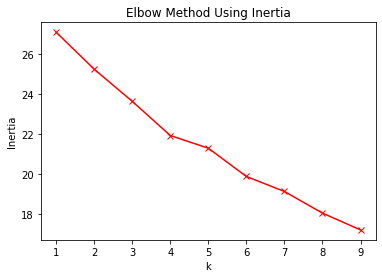

In [54]:
plt.plot(K, inertias, 'rx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method Using Inertia')
plt.show()

#### Plotting elbow using Canberra Metric
This metric allows defining an accurate value for k.

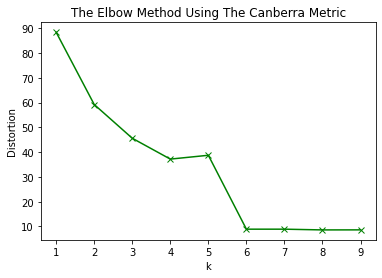

In [55]:
plt.plot(K, distortions, 'gx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method Using The Canberra Metric')
plt.show()

#### Running k-means to cluster neighbourhoods into 6 clusters

In [56]:
kclusters = 6
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(torontoFoodCategoriesClustered)
kmeans.labels_

array([3, 2, 2, 3, 0, 3, 3, 3, 2, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 2, 2, 3, 0, 2, 3, 2, 3, 2, 3, 3, 1, 3, 3, 2, 3, 3, 3, 4, 3,
       1, 3, 2, 3, 3, 0, 3, 2, 2, 0, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2,
       3, 3, 3, 3, 3, 0, 2, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 0,
       3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 2, 0, 5, 3, 0, 3, 0, 2, 2, 3, 3,
       3, 3, 3, 2, 2, 3, 3, 2, 3, 0, 2, 2, 2, 3, 3, 2])

#### Creating data frame with the 5 top venues in each neighborhood and cluster labels
Neighbourhoods where no food venues exist at all will be dropped since they don’t have a distinguished feature for clustering.

In [57]:
clusteredTorontoData = torontoTopFoodCategories[torontoTopFoodCategories['1st Most Common Venue'] != 'NoVenue']
clusteredTorontoData.reset_index(drop = True, inplace = True)
clusteredTorontoData.insert(0, 'Cluster_Number', kmeans.labels_)
clusteredTorontoData.head()

Cluster_Number                 Neighbourhood 1st Most Common Venue  \
0               3               Agincourt North        Sandwich Place   
1               2  Agincourt South-Malvern West           Pizza Place   
2               2                         Annex                  Café   
3               3             Banbury-Don Mills           Wings Joint   
4               0                Bathurst Manor    Chinese Restaurant   

  2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
0      Asian Restaurant               NoVenue                NoVenue   
1    Chinese Restaurant            Restaurant  Vietnamese Restaurant   
2        Sandwich Place           Pizza Place           Burger Joint   
3            Restaurant            Food Truck          Deli / Bodega   
4                  Café               NoVenue                NoVenue   

  5th Most Common Venue  
0               NoVenue  
1         Deli / Bodega  
2                 Diner  
3               NoVenue  
4               NoVenue

In [58]:
clusteredTorontoCommonData = pd.merge(neighbourhoods, clusteredTorontoData, how = 'right', on = 'Neighbourhood')
clusteredTorontoCommonData.head()

Neighbourhood  Covid_Cases_Total  Assault_Rate_mean  \
0               Agincourt North                527         244.798486   
1  Agincourt South-Malvern West                560         462.185571   
2                         Annex                310         833.750386   
3             Banbury-Don Mills                361         276.324557   
4                Bathurst Manor                624         344.008300   

   Burglaries_Rate_mean  Robbery_Rate_mean  Crimes_Total  Longitude  \
0            158.419463          94.582293          1067 -79.281616   
1            314.380986         102.594551          1565 -79.289169   
2            475.984500         152.495671          3346 -79.412147   
3            234.616229          46.386083          1141 -79.326505   
4            184.767071          66.344721           698 -79.430503   

    Latitude  Cluster_Number 1st Most Common Venue 2nd Most Common Venue  \
0  43.797406               3        Sandwich Place      Asian Restaurant   
1  43.785187               2           Pizza Place    Chinese Restaurant   
2  43.674431               2                  Café        Sandwich Place   
3  43.732570               3           Wings Joint            Restaurant   
4  43.757578               0    Chinese Restaurant                  Café   

  3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  
0               NoVenue                NoVenue               NoVenue  
1            Restaurant  Vietnamese Restaurant         Deli / Bodega  
2           Pizza Place           Burger Joint                 Diner  
3            Food Truck          Deli / Bodega               NoVenue  
4               NoVenue                NoVenue               NoVenue

#### Creating map of Toronto with clustered neighbourhoods

In [59]:
mapClusters = folium.Map(location = [torontoLatitude, torontoLongitude], zoom_start = 11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(clusteredTorontoCommonData['Latitude'], clusteredTorontoCommonData['Longitude'], clusteredTorontoCommonData['Neighbourhood'], clusteredTorontoCommonData['Cluster_Number']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster],
        fill = True,
        fill_color = rainbow[cluster],
        fill_opacity = 0.7).add_to(mapClusters)
       
mapClusters

### The map is stored as 'Clustered Toronto neighborhoods.png'

### Analyzing clusters

In many neighbourhoods the number of food venues is less than 3. 
So that we will consider the first two most common venues to determine an appropriate label for each cluster.

In [60]:
clusterLabelData = pd.DataFrame({'Cluster_Number': [0, 1, 2, 3, 4, 5], 'Cluster_Label': np.nan})
clusterLabelData

Cluster_Number  Cluster_Label
0               0            NaN
1               1            NaN
2               2            NaN
3               3            NaN
4               4            NaN
5               5            NaN

#### Cluster 0

In [61]:
clusteredTorontoCommonData.loc[clusteredTorontoCommonData['Cluster_Number'] == 0]

Neighbourhood  Covid_Cases_Total  Assault_Rate_mean  \
4        Bathurst Manor                624         344.008300   
27   Don Valley Village                462         440.654471   
49    Hillcrest Village                224         341.112957   
53              Ionview                309         677.322429   
71             Milliken                403         306.337643   
87      Oakwood Village                519         577.051800   
93          Regent Park                278        1109.196414   
100              Rustic                332         646.827814   
103             Steeles                346         158.163886   
105       Taylor-Massey                458         679.760386   
119              Woburn               1772         683.345600   

     Burglaries_Rate_mean  Robbery_Rate_mean  Crimes_Total  Longitude  \
4              184.767071          66.344721           698 -79.430503   
27             174.489071         108.885800          1436 -79.366220   
49             195.639056          94.777794           786 -79.369157   
53             179.431614          86.321817           932 -79.267509   
71             362.576271         126.436911          1562 -79.288587   
87             140.524980         123.287506          1303 -79.289643   
93             286.361957         171.369557          1307 -79.356450   
100            144.470820          91.034696           642 -79.501171   
103            201.592601          33.761799           713 -79.308988   
105            269.012171         138.138586          1245 -79.296870   
119            177.420471         144.742144          3953 -79.218358   

      Latitude  Cluster_Number  1st Most Common Venue  2nd Most Common Venue  \
4    43.757578               0     Chinese Restaurant                   Café   
27   43.790141               0     Chinese Restaurant  Vietnamese Restaurant   
49   43.795090               0     Chinese Restaurant  Vietnamese Restaurant   
53   43.730910               0     Chinese Restaurant            Pizza Place   
71   43.806744               0     Chinese Restaurant  Vietnamese Restaurant   
87   43.694527               0             Restaurant     Chinese Restaurant   
93   43.664490               0     Chinese Restaurant  Vietnamese Restaurant   
100  43.718561               0  Vietnamese Restaurant     Chinese Restaurant   
103  43.808276               0     Chinese Restaurant                NoVenue   
105  43.701139               0     Chinese Restaurant           Burger Joint   
119  43.749046               0      Indian Restaurant     Chinese Restaurant   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
4                 NoVenue               NoVenue               NoVenue  
27                 Bakery   Szechuan Restaurant      Sushi Restaurant  
49             Restaurant   Szechuan Restaurant        Sandwich Place  
53         Sandwich Place               NoVenue               NoVenue  
71              BBQ Joint                Bakery          Noodle House  
87         Sandwich Place  Fast Food Restaurant               NoVenue  
93                 Bakery  Fast Food Restaurant                  Café  
100  Caribbean Restaurant               NoVenue               NoVenue  
103               NoVenue               NoVenue               NoVenue  
105               NoVenue               NoVenue               NoVenue  
119           Pizza Place               NoVenue               NoVenue

Let's create a bar chart with the total number of venues in each food venue category.
We specify a threshold value for the number of venues in food venue categories to show the topmost ones.

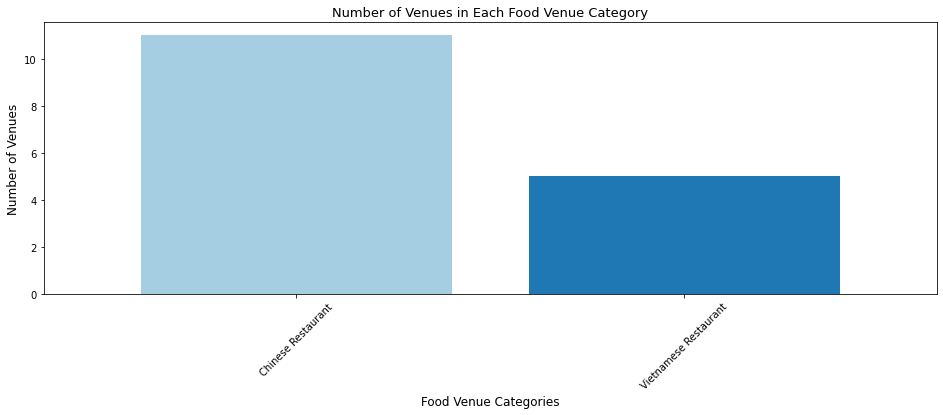

In [62]:
clusterVenuesCount0 = clusteredTorontoCommonData.loc[clusteredTorontoCommonData['Cluster_Number'] == 0]
clusterVenuesCount0 = clusterVenuesCount0.loc[:,['1st Most Common Venue', '2nd Most Common Venue']]
clusterVenuesCount0 = clusterVenuesCount0.stack().value_counts().to_frame()
clusterVenuesCount0.reset_index(inplace = True)
clusterVenuesCount0.columns = ['Food Venue', 'Counts']
clusterVenuesCount0 = clusterVenuesCount0.loc[clusterVenuesCount0['Counts'] > 1]

axes = clusterVenuesCount0.plot(kind = 'bar', figsize = (16, 5), width = 0.8, color = [plt.cm.Paired(np.arange(len(clusterVenuesCount0)))])
axes.set_xticklabels(clusterVenuesCount0['Food Venue'])
plt.title("Number of Venues in Each Food Venue Category",fontsize = 13)
plt.xticks(rotation = 45)
plt.xlabel('Food Venue Categories', fontsize = 12)
plt.ylabel('Number of Venues', fontsize = 12)
axes.get_legend().remove()

In [63]:
clusterLabelData.loc[0, 'Cluster_Label'] = 'Chinese & Vietnamese Restaurants'

#### Cluster 1

In [64]:
clusteredTorontoCommonData.loc[clusteredTorontoCommonData['Cluster_Number'] == 1]

Neighbourhood  Covid_Cases_Total  Assault_Rate_mean  \
35  Elms-Old Rexdale                423         581.084229   
44         Guildwood                191         400.497486   
94   Rexdale-Kipling                284         599.661986   

    Burglaries_Rate_mean  Robbery_Rate_mean  Crimes_Total  Longitude  \
35            113.037841         140.782291           576 -79.553080   
44            125.265359          76.541360           434 -79.205069   
94            147.583700         173.620300           705 -79.574165   

     Latitude  Cluster_Number 1st Most Common Venue 2nd Most Common Venue  \
35  43.729832               1    African Restaurant  Caribbean Restaurant   
44  43.753509               1  Caribbean Restaurant               NoVenue   
94  43.735540               1  Caribbean Restaurant     Indian Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
35               NoVenue               NoVenue               NoVenue  
44               NoVenue               NoVenue               NoVenue  
94               NoVenue               NoVenue               NoVenue

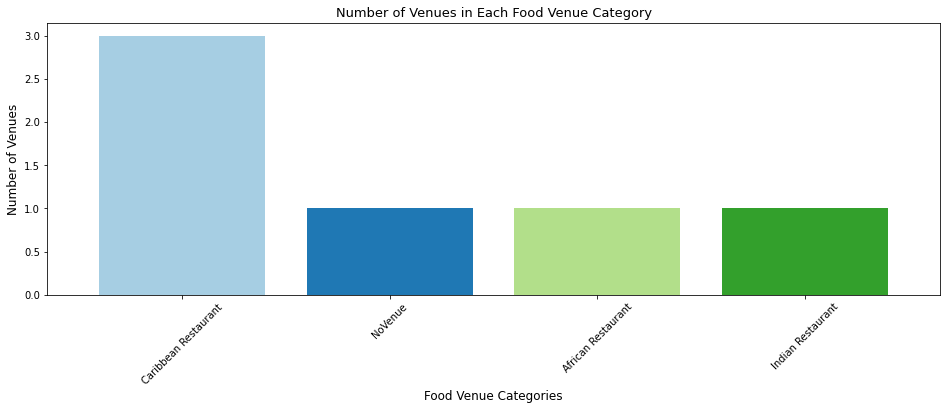

In [65]:
clusterVenuesCount1 = clusteredTorontoCommonData.loc[clusteredTorontoCommonData['Cluster_Number'] == 1]
clusterVenuesCount1 = clusterVenuesCount1.loc[:,['1st Most Common Venue', '2nd Most Common Venue']]
clusterVenuesCount1 = clusterVenuesCount1.stack().value_counts().to_frame()
clusterVenuesCount1.reset_index(inplace = True)
clusterVenuesCount1.columns = ['Food Venue', 'Counts']

axes = clusterVenuesCount1.plot(kind = 'bar', figsize = (16, 5), width = 0.8, color=[plt.cm.Paired(np.arange(len(clusterVenuesCount1)))])
axes.set_xticklabels(clusterVenuesCount1['Food Venue'])
plt.title("Number of Venues in Each Food Venue Category",fontsize= 13)
plt.xticks(rotation = 45)
plt.xlabel('Food Venue Categories', fontsize = 12)
plt.ylabel('Number of Venues', fontsize = 12)
axes.get_legend().remove()

In [66]:
clusterLabelData.loc[1, 'Cluster_Label'] = 'Caribbean Restaurants'

#### Cluster 2

In [67]:
clusteredTorontoCommonData.loc[clusteredTorontoCommonData['Cluster_Number'] == 2]

Neighbourhood  Covid_Cases_Total  \
1           Agincourt South-Malvern West                560   
2                                  Annex                310   
8                   Bedford Park-Nortown                372   
10                               Bendale                863   
12                           Black Creek               1074   
13                           Blake-Jones                113   
14                  Briar Hill-Belgravia                542   
22                   Clairlea-Birchmount                841   
24                Corso Italia-Davenport                387   
25                              Danforth                128   
28                           Dorset Park                785   
30                  Downsview-Roding-CFB               1794   
32                     East End-Danforth                355   
38                   Etobicoke West Mall                343   
46                       High Park North                313   
51                         Humber Summit                508   
52                    Humewood-Cedarvale                269   
60                        Kingsway South                 84   
61                            L'Amoreaux               1011   
65                   Lawrence Park South                131   
72   Mimico (includes Humber Bay Shores)                768   
75                          Mount Dennis                525   
79                           New Toronto                257   
81                      Newtonbrook West                739   
99          Runnymede-Bloor West Village                 99   
106                          The Beaches                162   
107         Thistletown-Beaumond Heights                350   
113                               Weston                843   
114                   Weston-Pellam Park                447   
117                      Willowdale West                228   
120                    Woodbine Corridor                181   
121                     Woodbine-Lumsden                157   
122                             Wychwood                265   
125                   Yorkdale-Glen Park                542   

     Assault_Rate_mean  Burglaries_Rate_mean  Robbery_Rate_mean  Crimes_Total  \
1           462.185571            314.380986         102.594551          1565   
2           833.750386            475.984500         152.495671          3346   
8           184.013829            364.735286          54.972441          1040   
10          764.784143            189.487603         181.174267          2490   
12         1055.178714            125.694029         187.100986          2175   
13          769.923071            284.109643         127.399896           669   
14          555.819800            249.211343         145.090817           997   
22          876.523629            318.604057         142.161030          2628   
24          581.348543            202.283543         155.613896           973   
25          946.492300            366.697729         261.721657          1112   
28          648.901071            288.545729         145.714101          1980   
30         1028.861729            216.305771         166.443629          3671   
32          787.755243            328.183657         149.069586          1979   
38          411.972786            126.576380          60.845566           521   
46          434.384957            200.011439         107.045419          1216   
51          856.500857            349.788171         209.189086          1292   
52          284.088471            229.921414          48.051689           598   
60          271.471971            247.528557         141.434474           450   
61          364.054057            149.442130          89.130144          1963   
65          135.010630            319.846429          42.477136           556   
72          828.761100            164.931186          49.921589          2629   
75          666.213971            143.7

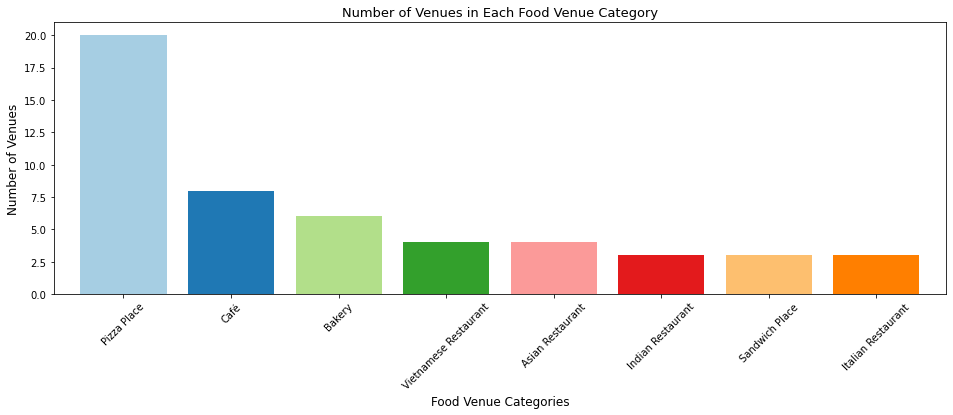

In [68]:
clusterVenuesCount2 = clusteredTorontoCommonData.loc[clusteredTorontoCommonData['Cluster_Number'] == 2]
clusterVenuesCount2 = clusterVenuesCount2.loc[:,['1st Most Common Venue', '2nd Most Common Venue']]
clusterVenuesCount2 = clusterVenuesCount2.stack().value_counts().to_frame()
clusterVenuesCount2.reset_index(inplace = True)
clusterVenuesCount2.columns = ['Food Venue', 'Counts']
clusterVenuesCount2 = clusterVenuesCount2.loc[clusterVenuesCount2['Counts'] > 2]

axes = clusterVenuesCount2.plot(kind='bar', figsize=(16, 5), width = 0.8, color=[plt.cm.Paired(np.arange(len(clusterVenuesCount2)))])
axes.set_xticklabels(clusterVenuesCount2['Food Venue'])
plt.title("Number of Venues in Each Food Venue Category",fontsize = 13)
plt.xticks(rotation = 45)
plt.xlabel('Food Venue Categories', fontsize = 12)
plt.ylabel('Number of Venues', fontsize = 12)
axes.get_legend().remove()

In [69]:
clusterLabelData.loc[2, 'Cluster_Label'] = 'Pizza places'

#### Cluster 3

In [70]:
clusteredTorontoCommonData.loc[clusteredTorontoCommonData['Cluster_Number'] == 3]

Neighbourhood  Covid_Cases_Total  \
0                        Agincourt North                527   
3                      Banbury-Don Mills                361   
5                    Bay Street Corridor                283   
6                        Bayview Village                234   
7                  Bayview Woods-Steeles                273   
9                Beechborough-Greenbrook                272   
11                 Birchcliffe-Cliffside                344   
15     Bridle Path-Sunnybrook-York Mills                112   
16                       Broadview North                235   
17                   Brookhaven-Amesbury                672   
18       Cabbagetown-South St.James Town                212   
19                    Caledonia-Fairbank                395   
20                             Casa Loma                124   
21                 Church-Yonge Corridor                537   
23                          Clanton Park                367   
26                    Danforth East York                339   
29   Dovercourt-Wallace Emerson-Junction                760   
31                        Dufferin Grove                248   
33              Edenbridge-Humber Valley                290   
34                         Eglinton East                701   
36                   Englemount-Lawrence                730   
37        Eringate-Centennial-West Deane                331   
39                       Flemingdon Park                744   
40                     Forest Hill North                261   
41                     Forest Hill South                104   
43                     Greenwood-Coxwell                195   
45                            Henry Farm                509   
47                     High Park-Swansea                223   
48                        Highland Creek                391   
50              Humber Heights-Westmount                298   
54            Islington-City Centre West                870   
55                         Junction Area                303   
56              Keelesdale-Eglinton West                475   
57                          Kennedy Park                556   
58                  Kensington-Chinatown                404   
59         Kingsview Village-The Westway                757   
62                    Lambton Baby Point                132   
63                      Lansing-Westgate                229   
64                   Lawrence Park North                126   
66                    Leaside-Bennington                183   
67                       Little Portugal                269   
68                               Malvern               1575   
69                            Maple Leaf                546   
70                         Markland Wood                193   
73                           Morningside                627   
74                             Moss Park                457   
76     Mount Olive-Silverstone-Jamestown               1228   
77                   Mount Pleasant East                157   
78                   Mount Pleasant West                539   
80                      Newtonbrook East                178   
82                               Niagara                442   
83                       North Riverdale                 93   
84                   North St.James Town                511   
85                     O'Connor-Parkview                391   
86                              Oakridge                493   
88               Palmerston-Little Italy                182   
89                     Parkwoods-Donalda                917   
90                  Pelmo Park-Humberlea                483   
91              Playter Estates-Danforth                104   
92                         Pleasant View                422   
95                     Rockcliffe-Smythe                878   
96                          Roncesvalles                191   
97                   Rosedale-Moore Park                21

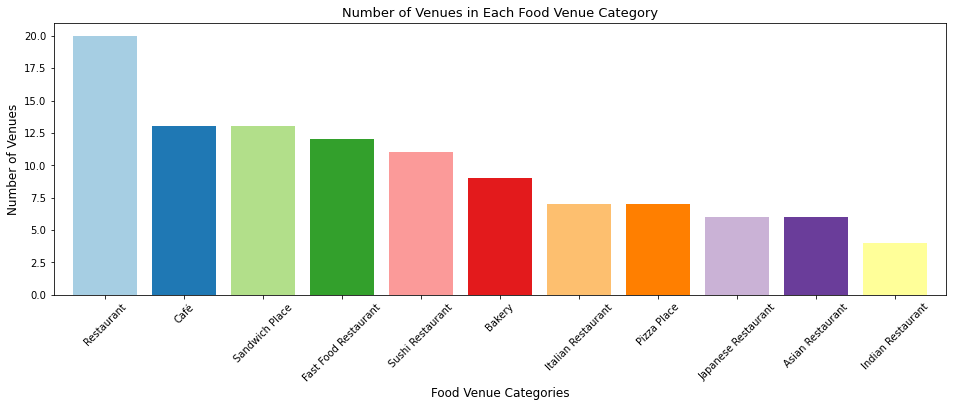

In [71]:
clusterVenuesCount3 = clusteredTorontoCommonData.loc[clusteredTorontoCommonData['Cluster_Number'] == 3]
clusterVenuesCount3 = clusterVenuesCount3.loc[:,['1st Most Common Venue', '2nd Most Common Venue']]
clusterVenuesCount3 = clusterVenuesCount3.stack().value_counts().to_frame()
clusterVenuesCount3.reset_index(inplace = True)
clusterVenuesCount3.columns = ['Food Venue', 'Counts']
clusterVenuesCount3 = clusterVenuesCount3.loc[clusterVenuesCount3['Counts'] > 3]

axes = clusterVenuesCount3.plot(kind='bar', figsize = (16, 5), width = 0.8, color=[plt.cm.Paired(np.arange(len(clusterVenuesCount3)))])
axes.set_xticklabels(clusterVenuesCount3['Food Venue'])
plt.title("Number of Venues in Each Food Venue Category",fontsize = 13)
plt.xticks(rotation = 45)
plt.xlabel('Food Venue Categories', fontsize = 12)
plt.ylabel('Number of Venues', fontsize = 12)
axes.get_legend().remove()

In [72]:
clusterLabelData.loc[3, 'Cluster_Label'] = 'Various Restaurants and Fast Food Places'

#### Cluster 4

In [73]:
clusteredTorontoCommonData.loc[clusteredTorontoCommonData['Cluster_Number'] == 4]

Neighbourhood  Covid_Cases_Total  Assault_Rate_mean  \
42  Glenfield-Jane Heights               1352           921.6823   

    Burglaries_Rate_mean  Robbery_Rate_mean  Crimes_Total  Longitude  \
42            118.810156         153.898729          2680 -79.505334   

     Latitude  Cluster_Number      1st Most Common Venue  \
42  43.757903               4  Middle Eastern Restaurant   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
42               NoVenue               NoVenue               NoVenue   

   5th Most Common Venue  
42               NoVenue

In [74]:
clusterLabelData.loc[4, 'Cluster_Label'] = 'Middle Eastern Restaurant'

In [75]:
clusteredTorontoCommonData.loc[clusteredTorontoCommonData['Cluster_Number'] == 5]

Neighbourhood  Covid_Cases_Total  Assault_Rate_mean  \
101  South Parkdale                558         934.613486   

     Burglaries_Rate_mean  Robbery_Rate_mean  Crimes_Total  Longitude  \
101            290.790243         122.705551          2194 -79.438836   

      Latitude  Cluster_Number 1st Most Common Venue 2nd Most Common Venue  \
101  43.632999               5   American Restaurant               NoVenue   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
101               NoVenue               NoVenue               NoVenue

In [76]:
clusterLabelData.loc[5, 'Cluster_Label'] = 'American Restaurant'

In [77]:
clusterLabelData

Cluster_Number                             Cluster_Label
0               0          Chinese & Vietnamese Restaurants
1               1                     Caribbean Restaurants
2               2                              Pizza places
3               3  Various Restaurants and Fast Food Places
4               4                 Middle Eastern Restaurant
5               5                       American Restaurant

Analyzed the bar charts we can provide the following cluster labels:

* Cluster 0 : "Chinese & Vietnamese Restaurants"
* Cluster 1 : "Caribbean Restaurants"
* Cluster 2 : "Pizza places"
* Cluster 3 : "Various Restaurants and Fast Food Places"
* Cluster 4 : "Middle Eastern Restaurant" 
* Cluster 5 : "American Restaurant" 

### Visualization of clustered and non-clustered neighbourhoods

Let's create data frames of Toronto with clustered and non-clustered neighborhoods with all data.

#### Creating data frame with all data for clustered neighbourhoods

In [78]:
clusteredTorontoCommonData = pd.merge(neighbourhoods, clusteredTorontoData, how = 'right', on = 'Neighbourhood')
clusteredTorontoCommonData = pd.merge(clusteredTorontoCommonData, clusterLabelData, how ='left', on = 'Cluster_Number')
clusteredTorontoCommonData.head()

Neighbourhood  Covid_Cases_Total  Assault_Rate_mean  \
0               Agincourt North                527         244.798486   
1  Agincourt South-Malvern West                560         462.185571   
2                         Annex                310         833.750386   
3             Banbury-Don Mills                361         276.324557   
4                Bathurst Manor                624         344.008300   

   Burglaries_Rate_mean  Robbery_Rate_mean  Crimes_Total  Longitude  \
0            158.419463          94.582293          1067 -79.281616   
1            314.380986         102.594551          1565 -79.289169   
2            475.984500         152.495671          3346 -79.412147   
3            234.616229          46.386083          1141 -79.326505   
4            184.767071          66.344721           698 -79.430503   

    Latitude  Cluster_Number 1st Most Common Venue 2nd Most Common Venue  \
0  43.797406               3        Sandwich Place      Asian Restaurant   
1  43.785187               2           Pizza Place    Chinese Restaurant   
2  43.674431               2                  Café        Sandwich Place   
3  43.732570               3           Wings Joint            Restaurant   
4  43.757578               0    Chinese Restaurant                  Café   

  3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
0               NoVenue                NoVenue               NoVenue   
1            Restaurant  Vietnamese Restaurant         Deli / Bodega   
2           Pizza Place           Burger Joint                 Diner   
3            Food Truck          Deli / Bodega               NoVenue   
4               NoVenue                NoVenue               NoVenue   

                              Cluster_Label  
0  Various Restaurants and Fast Food Places  
1                              Pizza places  
2                              Pizza places  
3  Various Restaurants and Fast Food Places  
4          Chinese & Vietnamese Restaurants

#### Creating data frame with all data for non-clustered neighbourhoods

In [79]:
nonClusteredTorontoData = torontoTopFoodCategories[torontoTopFoodCategories['1st Most Common Venue'] == 'NoVenue']
nonClusteredTorontoCommonData = pd.merge(neighbourhoods, nonClusteredTorontoData, how = 'right', on = 'Neighbourhood')
nonClusteredTorontoCommonData.head()

Neighbourhood  Covid_Cases_Total  Assault_Rate_mean  \
0               Alderwood                222         287.495757   
1  Centennial Scarborough                258         332.824714   
2              Cliffcrest                395         673.169171   
3              Humbermede                841         731.669271   
4             Long Branch                209         585.183371   

   Burglaries_Rate_mean  Robbery_Rate_mean  Crimes_Total  Longitude  \
0            209.450686          61.767394           497 -79.553204   
1            124.137040          42.164441           490 -79.145626   
2            281.115271         146.171497          1297 -79.225220   
3            221.528786         149.759330          1261 -79.549080   
4            283.050829         136.637676           759 -79.524738   

    Latitude 1st Most Common Venue 2nd Most Common Venue  \
0  43.595500               NoVenue               NoVenue   
1  43.769728               NoVenue               NoVenue   
2  43.711273               NoVenue               NoVenue   
3  43.735709               NoVenue               NoVenue   
4  43.589748               NoVenue               NoVenue   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0               NoVenue               NoVenue               NoVenue  
1               NoVenue               NoVenue               NoVenue  
2               NoVenue               NoVenue               NoVenue  
3               NoVenue               NoVenue               NoVenue  
4               NoVenue               NoVenue               NoVenue

#### Creating map of Toronto with clustered and non-clustered neighbourhoods

In [80]:
mapClusters = folium.Map(location = [torontoLatitude, torontoLongitude], zoom_start = 11)

for lat, lon, nb, clNum, clLbl in zip(clusteredTorontoCommonData['Latitude'], clusteredTorontoCommonData['Longitude'], clusteredTorontoCommonData['Neighbourhood'], clusteredTorontoCommonData['Cluster_Number'], clusteredTorontoCommonData['Cluster_Label']):
    label = folium.Popup(str(nb) + ' / Cluster: ' + str(clLbl), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[clNum],
        fill = True,
        fill_color = rainbow[clNum],
        fill_opacity = 0.7).add_to(mapClusters)
    
#The non-clustered neighbourhoods are designated with grey colour.
for lat, lon, poi in zip(nonClusteredTorontoCommonData['Latitude'], nonClusteredTorontoCommonData['Longitude'], nonClusteredTorontoCommonData['Neighbourhood']):
    label = folium.Popup(str(poi) + ' - No Food Venues', parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = '#808080',
        fill = True,
        fill_color = '#808080',
        fill_opacity = 0.7).add_to(mapClusters)
mapClusters

### The map is stored in 'Clustered and non-clustered Toronto neighborhoods.png'

## Results

Let's visualize the labeled Toronto neighbourhoods on the choropleth map showing COVID-19 rate.

#### Processing neighbourhood geometries

In [81]:
with urlopen('https://raw.githubusercontent.com/jasonicarter/toronto-geojson/master/toronto_crs84.geojson') as response:
    neighbourhoodGeometriesCollection = json.load(response)

for num, neighbourhoodGeometry in enumerate(neighbourhoodGeometriesCollection["features"]):
    neighbourhoodName = neighbourhoodGeometry['properties']['AREA_NAME']
    neighbourhoodName = re.sub('\s+\(\d+\)', '', neighbourhoodName)
    neighbourhoodGeometry['properties']['AREA_NAME'] = neighbourhoodName
    if neighbourhoodName not in neighbourhoods['Neighbourhood'].to_list():
        print(neighbourhoodName)

#### Creating choropleth map of Toronto with labeled Toronto neighbourhoods showing COVID-19 rate

In [82]:
mapClusters = folium.Map(location = [torontoLatitude, torontoLongitude], zoom_start = 11)
mapClusters.choropleth(
    geo_data = neighbourhoodGeometriesCollection,
    data = neighbourhoods,
    columns = ['Neighbourhood','Covid_Cases_Total'],
    key_on = 'feature.properties.AREA_NAME',
    fill_color = 'YlOrRd', 
    fill_opacity = 0.7, 
    line_opacity = 0.2,
    legend_name = 'Number of COVID-19 cases',
    highlight = True
)

for lat, lon, nb, clNum, clLbl in zip(clusteredTorontoCommonData['Latitude'], clusteredTorontoCommonData['Longitude'], clusteredTorontoCommonData['Neighbourhood'], clusteredTorontoCommonData['Cluster_Number'], clusteredTorontoCommonData['Cluster_Label']):
    label = folium.Popup(str(nb) + ' / Cluster: ' + str(clLbl), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[clNum],
        fill = True,
        fill_color = rainbow[clNum],
        fill_opacity = 0.7).add_to(mapClusters)

#The non-clustered neighbourhoods are designated with grey colour.    
for lat, lon, poi in zip(nonClusteredTorontoCommonData['Latitude'], nonClusteredTorontoCommonData['Longitude'], nonClusteredTorontoCommonData['Neighbourhood']):
    label = folium.Popup(str(poi) + ' - No Food Venues', parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = '#808080',
        fill = True,
        fill_color ='#808080',
        fill_opacity = 0.7).add_to(mapClusters)    
mapClusters

### The map is stored as 'Choropleth map of Toronto with labeled Toronto neighbourhoods showing COVID-19 rate.png'

Let's visualize the labeled Toronto neighbourhoods on the choropleth map showing crime rate.

The corresponding map with the crime rate of each type per 100,000 population might have been presented. However, it wouldn't show significantly important results. 

#### Creating choropleth map of Toronto with labeled Toronto neighbourhoods showing crime rate

In [83]:
mapClusters = folium.Map(location = [torontoLatitude, torontoLongitude], zoom_start = 11)
mapClusters.choropleth(
    geo_data = neighbourhoodGeometriesCollection,
    data = neighbourhoods,
    columns = ['Neighbourhood','Crimes_Total'],
    key_on = 'feature.properties.AREA_NAME',
    fill_color = 'YlOrRd', 
    fill_opacity = 0.7, 
    line_opacity = 0.2,
    legend_name = 'Number of crimes',
    highlight = True
)


for lat, lon, nb, clNum, clLbl in zip(clusteredTorontoCommonData['Latitude'], clusteredTorontoCommonData['Longitude'], clusteredTorontoCommonData['Neighbourhood'], clusteredTorontoCommonData['Cluster_Number'], clusteredTorontoCommonData['Cluster_Label']):
    label = folium.Popup(str(nb) + ' / Cluster: ' + str(clLbl), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[clNum],
        fill = True,
        fill_color = rainbow[clNum],
        fill_opacity = 0.7).add_to(mapClusters)

#The non-clustered neighbourhoods are designated with grey colour. 
for lat, lon, poi in zip(nonClusteredTorontoCommonData['Latitude'], nonClusteredTorontoCommonData['Longitude'], nonClusteredTorontoCommonData['Neighbourhood']):
    label = folium.Popup(str(poi) + ' - No Food Venues', parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = '#808080',
        fill = True,
        fill_color = '#808080',
        fill_opacity = 0.7).add_to(mapClusters)
mapClusters

### The map is stored as 'Choropleth map of Toronto with labeled Toronto neighbourhoods showing crime rate.png'

## Discussion 

Our analysis shows that Toronto can offer a good opportunity to run a catering business. On the one hand a lot of food venues of different categories have already opened in the city. And it may seem that a serious competition is observed and owners of new food venues will be confronted with difficulties. However, having explored carefully the obtained data, we can come to conclusion that there are many different opportunities for the new owners.

Firstly, there are several neighbourhoods in Toronto where there are no food venues at all. Certainly, the reasons why food venues are absent in them should be clarified. However, it is seen from the map with labeled Toronto neighbourhoods that the ones where no food venues exist are located closer to the outskirts of the city. Then we can see that venues of some categories are really in demand as for instance pizza and sandwich places, cafes and several types of restaurants, especially the Chinese, Italian, Sushi and fast food ones. Thus opening a venue of any of these categories will be quite risky in neighbourhoods where they already exist but the other ones can be considered.

We should also take into account the fact that in many neighbourhoods there are only a few food venues. Moreover, in the bar charts with the total number of venues in topmost food venue categories we considered the first two most common venues. That means that only a few venues of less popular category may exist. So that the right decision will be to examine neighbourhoods which are not full of food venues. After that it will be useful to analyze what venues may fit in such neighbourhoods.

Finally, the crime rate and the COVID-19 rate were analyzed and shown on the choropleth maps. It is seen that Toronto is a really safe city and only in a few neighbourhoods the number of crimes is larger comparatively with the other ones. The number of COVID-19 cases is quite small for such a big city. Thus according to the obtained results most of neighbourhoods satisfy client's requirements on safety.

## Conclusion

In the analysis we gathered various data on Toronto neighbourhoods explore them and apply cluster analysis to extract significant insights. We assessed the obtained results and visualized them on the interactive maps. We clarified our observations to determine where a new public catering establishment can be open and what kind of food venue it can be.